In [1]:
# Ref: https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1
# https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1
# https://zhuanlan.zhihu.com/p/34904202

### Import

In [1]:
import time
import numpy as np
import pandas as pd
import featuretools as ft
import catboost
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import scipy.optimize
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# New features

# 是否為頂樓

# all_data[‘top_floor’] = np.where((all_data[‘total_floor’] == all_data[‘txn_floor’]) , 1,
# 0)

# 屋齡

# all_data['house_day'] = all_data['txn_dt'] - all_data['building_complete_dt’]

# New_town =city + town

# all_data['new_town'] = all_data['city'].apply(str) + '_' + all_data['town'].apply(str)


In [2]:
# LabelEncode
train = pd.read_csv("train.csv", index_col=None)
test = pd.read_csv("test.csv", index_col=None)

In [4]:
print(train.shape)
print(test.shape)

(60000, 235)
(10000, 234)


### EDA

In [5]:
print(train.head())
print(train.columns)

        building_id  building_material  city  txn_dt  total_floor  \
0  e3mMIMR3JJqCaXz1                  8    21   18674            4   
1  LgwzgklNvy4QCtq5                  8     7   18800            5   
2  ucIR2NLLsC3T650L                  8     7   19289            4   
3  jre1pJhcQj91Kdky                  8    21   20385           24   
4  rQpYpY9nRG7X5mmr                  1    21   20657            2   

   building_type  building_use  building_complete_dt  parking_way  \
0              3             2                  6271            2   
1              1             2                  7885            2   
2              1             2                  6028            2   
3              0             2                 18325            0   
4              4             2                  6880            2   

   parking_area  ...  XIV_500  XIV_index_500  XIV_1000  XIV_index_1000  \
0           NaN  ...       58              1       157               1   
1           NaN  ...  

In [6]:
train.columns = [colname.lower() for colname in train.columns.values.tolist()]
test.columns = [colname.lower() for colname in test.columns.values.tolist()]

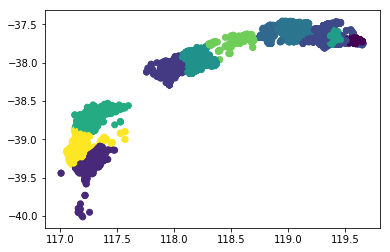

In [7]:
plt.scatter(train["lon"], train["lat"], c=train["city"])  # 經緯度可判斷蛋黃區

In [9]:
train.describe()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,xiv_500,xiv_index_500,xiv_1000,xiv_index_1000,xiv_5000,xiv_index_5000,xiv_10000,xiv_index_10000,xiv_min,total_price
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,3103.000000,1.393500e+04,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0,60000.000000,60000.0,60000.000000,6.000000e+04
mean,7.267917,11.414533,19488.957917,7.638250,1.931817,2.319200,11050.437183,1.585700,7.211837,5.025058e+04,...,60.867700,0.995800,252.823100,0.999867,5276.668033,1.0,16474.836600,1.0,101.044751,1.293727e+07
std,2.170741,4.751677,727.331019,5.070314,1.589972,1.399528,4344.018090,0.778952,20.453902,3.973488e+04,...,88.512972,0.064672,322.694074,0.011546,3856.219059,0.0,8998.020659,0.0,80.216061,5.522463e+07
min,1.000000,3.000000,18112.000000,1.000000,0.000000,0.000000,123.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,19.000000,1.0,30.000000,1.0,0.064766,2.261495e+05
25%,8.000000,7.000000,18892.750000,4.000000,0.000000,2.000000,7186.000000,2.000000,3.738412,2.827238e+04,...,20.000000,1.000000,88.000000,1.000000,2672.000000,1.0,8859.000000,1.0,49.182384,2.433114e+06
50%,8.000000,12.000000,19527.000000,5.000000,1.000000,2.000000,11507.000000,2.000000,5.758023,4.379195e+04,...,36.000000,1.000000,154.000000,1.000000,3942.000000,1.0,14344.000000,1.0,83.216237,5.240482e+06
75%,8.000000,13.000000,20125.000000,12.000000,4.000000,2.000000,14519.000000,2.000000,7.180619,6.148857e+04,...,64.000000,1.000000,275.000000,1.000000,6647.000000,1.0,23459.250000,1.0,130.779416,1.123932e+07
max,11.000000,21.000000,20665.000000,29.000000,4.000000,10.000000,20577.000000,2.000000,967.370868,1.020404e+06,...,1681.000000,1.000000,3463.000000,1.000000,18268.000000,1.0,32908.000000,1.0,1106.382478,5.088279e+09


#### Data type

In [10]:
bool_index = [col for col in train.columns if "index" in col]
qualitative = ["building_material", "city", "town", "village", "building_type", "building_use", "parking_way"]
qualitative

['building_material',
 'city',
 'town',
 'village',
 'building_type',
 'building_use',
 'parking_way']

In [11]:
# train["age_of_house"] = train["txn_dt"] - train["building_complete_dt"]
quantitative = [f for f in train.columns if f not in qualitative]
quantitative.remove('total_price')
quantitative.remove('building_id')
quantitative

['txn_dt',
 'total_floor',
 'building_complete_dt',
 'parking_area',
 'parking_price',
 'txn_floor',
 'land_area',
 'building_area',
 'lat',
 'lon',
 'village_income_median',
 'town_population',
 'town_area',
 'town_population_density',
 'doc_rate',
 'master_rate',
 'bachelor_rate',
 'jobschool_rate',
 'highschool_rate',
 'junior_rate',
 'elementary_rate',
 'born_rate',
 'death_rate',
 'marriage_rate',
 'divorce_rate',
 'n_50',
 'n_500',
 'n_1000',
 'n_5000',
 'n_10000',
 'i_10',
 'i_50',
 'i_index_50',
 'i_100',
 'i_250',
 'i_500',
 'i_index_500',
 'i_1000',
 'i_index_1000',
 'i_5000',
 'i_index_5000',
 'i_10000',
 'i_index_10000',
 'i_min',
 'ii_10',
 'ii_50',
 'ii_index_50',
 'ii_100',
 'ii_250',
 'ii_500',
 'ii_index_500',
 'ii_1000',
 'ii_index_1000',
 'ii_5000',
 'ii_index_5000',
 'ii_10000',
 'ii_index_10000',
 'ii_min',
 'iii_10',
 'iii_50',
 'iii_index_50',
 'iii_100',
 'iii_250',
 'iii_500',
 'iii_index_500',
 'iii_1000',
 'iii_index_1000',
 'iii_5000',
 'iii_index_5000',
 'i

#### Missing

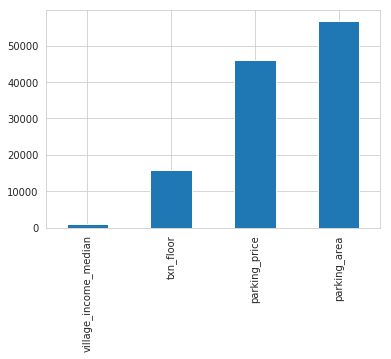

In [20]:
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

#### Outlier of y

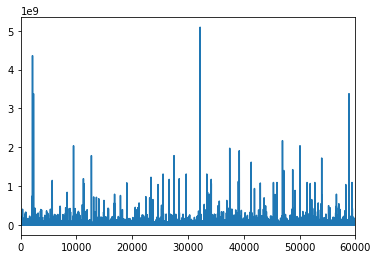

In [12]:
train["total_price"].plot()

#### Normality

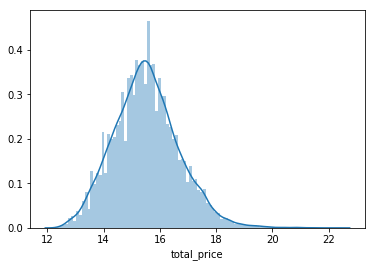

In [45]:
y = np.log1p(train["total_price"])
sns.distplot(y, bins=100)
# plt.figure(1); plt.title('Johnson SU')
# sns.distplot(y, kde=False, fit=stats.johnsonsu, bins=200)
# plt.figure(2); plt.title('Normal')
# sns.distplot(y, kde=False, fit=stats.norm)
# plt.figure(3); plt.title('Log Normal')
# sns.distplot(y, kde=False, fit=stats.lognorm)

In [13]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())  # False -> none of them is normal

/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be

/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be

/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be

False


/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be

#### Spearman

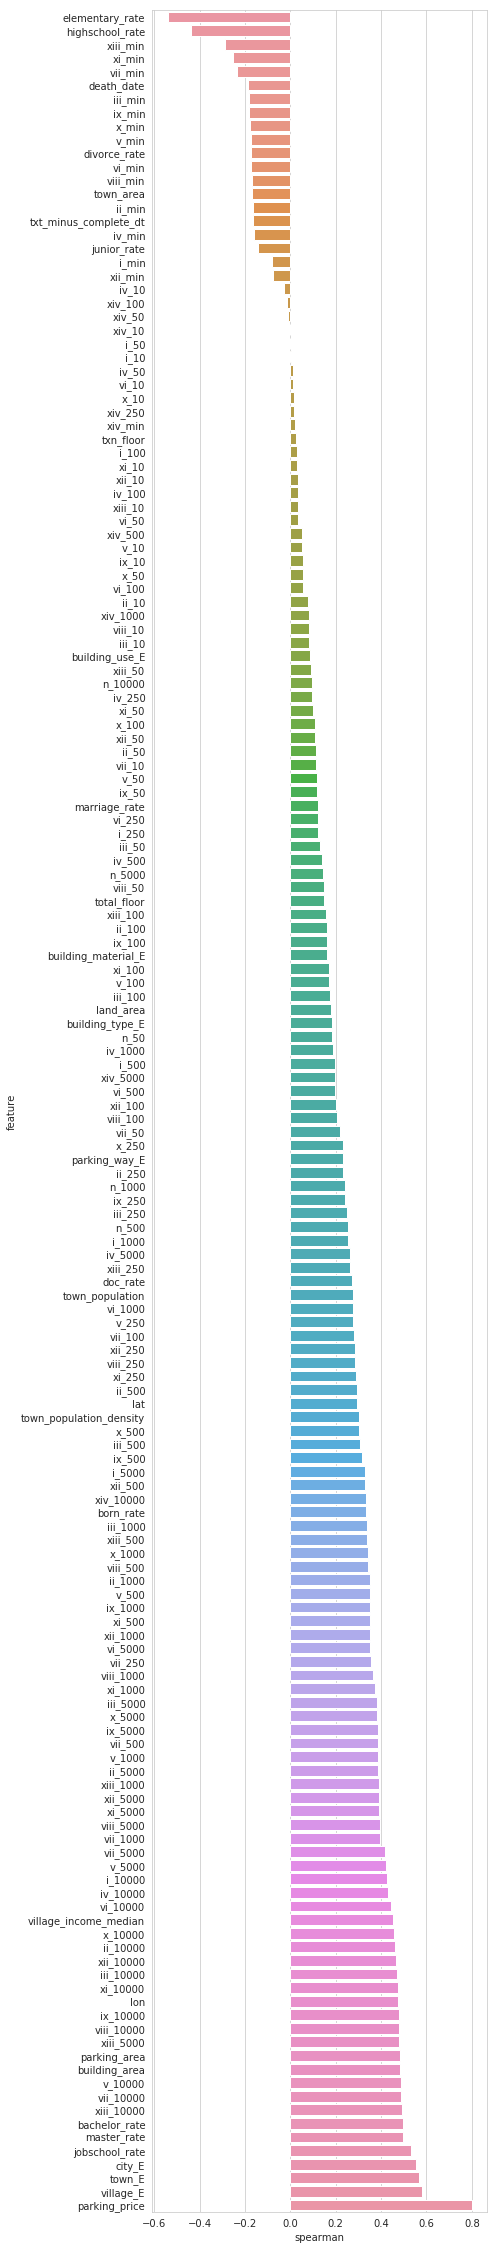

In [47]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['total_price'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(train, quantitative)

#### Pearson

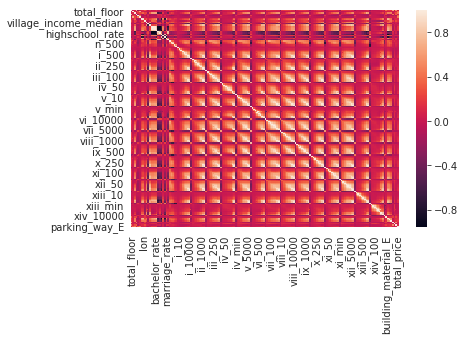

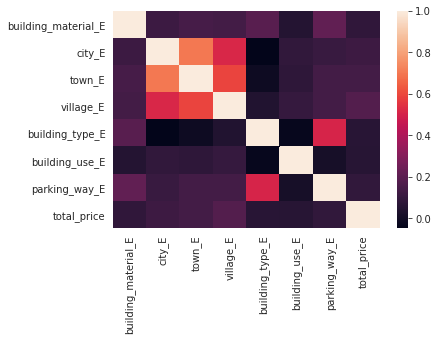

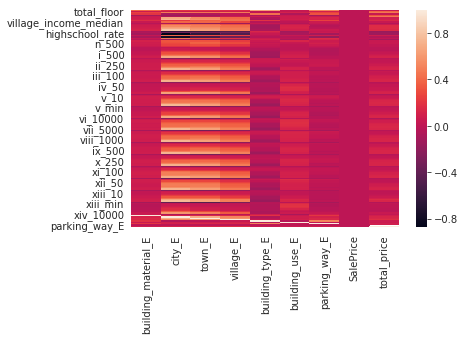

In [81]:
plt.figure(1)
corr = train[quantitative + ['total_price']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded + ['total_price']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['total_price']:
    for q2 in qual_encoded+['total_price']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

### 特徵工程

#### 比賽指標: Hit Rate + MAPE

![title](./Hit_Rate_1.png)
![title](./Hit_Rate計算_2.PNG)
![title](計分例子1.PNG)
![title](計分例子2.PNG)

In [2]:
def mape(y_true, y_hat):
    return np.sum(np.abs((y_true - y_hat) / y_true)) / len(y_true)
# mape(y_hat=np.array([1300, 1100, 1050]), y_true=np.array([1000, 1000, 1000]))

def hit_rate(y_true, y_hat):
    if_ten_pct = (np.abs((y_true - y_hat) / y_true) <= 0.1).astype(int)
    return np.round(np.sum(if_ten_pct) / len(y_true), 4) * 10**4 + (1 - mape(y_true, y_hat)) 
# hit_rate(y_hat=np.array([1300, 1100, 1050]), y_true=np.array([1000, 1000, 1000]))  # 6667.85

#### Data preprocessing

In [3]:
# 
train = pd.read_csv("train.csv", index_col=None)
test = pd.read_csv("test.csv", index_col=None)

train.columns = [colname.lower() for colname in train.columns.values.tolist()]
test.columns = [colname.lower() for colname in test.columns.values.tolist()]

train.drop(['building_id'], axis=1, inplace=True)
test.drop(['building_id'], axis=1, inplace=True)

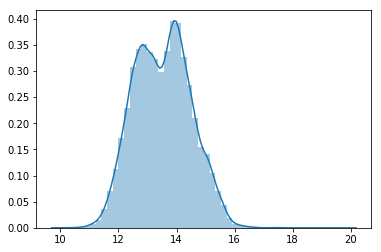

In [4]:
# 改為預測每單位建物面積價格
sns.distplot(np.log1p(train['total_price'] / train['building_area']))
train["total_price"] = train['total_price'] / train['building_area']
# train["unit_price"] = np.log1p(train["unit_price"])
train["total_price"] = np.log1p(train["total_price"])
y = train["total_price"]

#### 訓練測試組合起來一起做

In [5]:
train_features = train.drop(['total_price'], axis=1)
test_features = test.copy()
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(70000, 233)

In [6]:
# 補missing
all_features.isnull().sum()
all_features["parking_area"] = all_features["parking_area"].fillna(0)
all_features["parking_price"] = all_features["parking_price"].fillna(0)
# 透天厝的交易樓層填0 (另一種型態的交易)
all_features["txn_floor"] = all_features["txn_floor"].fillna(0)

In [7]:
# village_income_median有缺值用同city的去補
city_village_median_df = all_features[["city", "village_income_median"]].groupby("city", as_index=False).median()
city_village_median_df

,city,village_income_median
0,3,593.0
1,5,589.0
2,6,568.0
3,7,618.0
4,9,796.0
5,10,668.0
6,12,614.0
7,13,746.0
8,14,615.0
9,17,625.0


In [8]:
for c in all_features["city"].unique():
    all_features.loc[all_features["village_income_median"].isnull() & 
                 all_features["city"].eq(c), 
                 ["city", "village_income_median"]] = city_village_median_df.loc[city_village_median_df["city"].eq(c), "village_income_median"].values[0]

In [9]:
# Skew

# skew_features = all_features[quantitative].apply(lambda x: skew(x)).sort_values(ascending=False)
# print(skew_features)

# high_skew = skew_features[skew_features > 0.5]
# skew_index = high_skew.index

# for i in skew_index:
#     features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [10]:
# 是否有車位
all_features["has_parking_area"] = all_features["parking_area"].apply(lambda x: 1 if x > 0 else 0)
# 結婚成長率
all_features["marriage_growth"] = all_features["marriage_rate"] - all_features["divorce_rate"]
# 人口成長率
all_features["population_growth"] = all_features["born_rate"] - all_features["death_rate"]
# 屋齡
all_features["txt_minus_complete_dt"] = all_features["txn_dt"] - all_features["building_complete_dt"]
# 城市鄉鎮 (只留城市看看)
all_features["city_town"] = all_features["city"].apply(str) + all_features["town"].apply(str)
# all_features.drop(["city", "town"], axis=1, inplace=True)
all_features.drop(["city_town", "town"], axis=1, inplace=True)
# 是否為頂樓
all_features["top_floor"] = np.where(all_features["total_floor"]==all_features["txn_floor"] ,1, 0)
# 移除village(level太多可能出現train, test不match情況)
all_features.drop(["village"], axis=1, inplace=True)
# 
all_features.shape

(70000, 236)

In [11]:
# label encode for lgb
# le = preprocessing.LabelEncoder()
# le.fit(all_features["city_town"])
# all_features["city_town"] = le.transform(all_features["city_town"])

In [12]:
X = all_features.iloc[:len(y), :]
X_test = all_features.iloc[len(y):, :]
X.shape, y.shape, X_test.shape

((60000, 236), (60000,), (10000, 236))

In [13]:
# qualitative = ["building_material", "city_town", "village", "building_type", "building_use", "parking_way"]
qualitative = ["building_material", "city", "building_type", "building_use", "parking_way"]
quantitative = [f for f in train.columns if f not in qualitative]

In [14]:
# qualitative.extend(["has_parking_area", "has_building_area", "has_land_area"])
# qualitative.extend(i_cat_features)
# i_cat_features = [col for col in X.columns if col not in quantitative]
# qualitative = [cat_col for cat_col in features.columns if cat_col not in qu]
categorical_feature_idx = list(np.where(X.columns.isin(qualitative))[0])

In [15]:
# Your data contains string(?) values. You should set categorical columns in pandas to treat them properly. 
# After that there is no need to pass them again in categorical_feature param. 
model_type = 'lgb'
for col in X.columns[categorical_feature_idx]:
    # for catboost
    if model_type == 'cat':
        X[col] = X[col].astype('str')
        X_test[col] = X_test[col].astype('str')
        print(col)
        print(X[col].dtype)
    else:
        X[col] = X[col].astype('category')
        X_test[col] = X_test[col].astype('category')
        print(col)
        print(X[col].dtype)
# X['city_town'] = X['city_town'].astype('str')

building_material
category
city
category
building_type
category
building_use
category
parking_way
category


In [16]:
from sklearn.model_selection import train_test_split

# splitting train data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=11)
# X_train = pd.concat([X_train] * 2)
# y_train = pd.concat([y_train] * 2)
# val set再切一半出來當test set
X_val, X_val_test, y_val, y_val_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=11)

##### Catboost

In [15]:
# train不起來可能是因為cat index搞錯或有Na/ Cat對training set size很敏感?? -> 不，是去掉village好很多
# Catboost
model_cat = catboost.CatBoostRegressor(iterations=50000,
                              learning_rate=0.005,
                              depth=10,
                              eval_metric='RMSE',
                              # random_seed=11,
                              # l2_leaf_reg=4,
                              # one_hot_max_size=100,
                              # rsm=0.5,
                              metric_period=100,
                              # plot=True,
                              # subsample=0.5,
                              early_stopping_rounds=100)
model_cat.fit(X_train, y_train, eval_set=(X_val, y_val), 
              cat_features=categorical_feature_idx, 
              use_best_model=True)
model_cat.save_model("(After)cat_model_total_1hot(nVillage_nTown).dump")

KeyError: 6

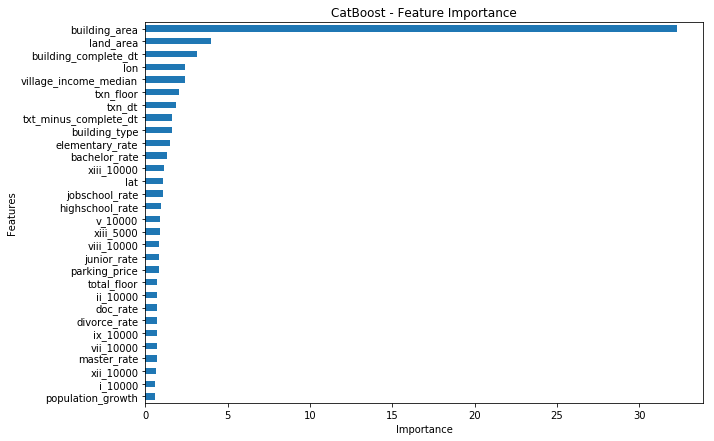

In [23]:
fea_imp = pd.DataFrame({'imp': model_cat.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [24]:
# Cat計算val分數 (y_val也要轉換回來總價)

# 總價版本
y_val_orig = np.expm1(y_val_test)
pred_price_cat = model_cat.predict(X_val_test)
pred_price_cat = np.expm1(pred_price_cat)

# unit price版本
# y_val_orig = np.expm1(y_val * X_val["building_area"])

# pred_val = model_cat.predict(X_val)
# pred_val = np.expm1(pred_val * X_val["building_area"])

print("Hit Rate:", hit_rate(y_true=y_val_orig, y_hat=pred_price_cat))

Hit Rate: 5707.873456107051


##### LightGBM (GBDT)

In [16]:
# lightGBM (gbdt)
model_lgb = LGBMRegressor(objective='regression',
                             boosting_type='gbdt',
                             num_leaves=31,  # < 2^max_depth
                             # reg_lambda=1,
                             learning_rate=0.003,
                             n_estimators=50000,
                             # max_bin=200, # default=255
                             bagging_fraction=0.8,
                             # bagging_freq=5, 
                             # bagging_seed=7,
                             feature_fraction=0.8,
                             # early_stopping_rounds=100
                             # feature_fraction_seed=7
                         )

print_callback = lgb.print_evaluation(period=500)

model_lgb.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              # categorical_feature=categorical_feature_idx,
              early_stopping_rounds=100,
              verbose=0,
              callbacks=[print_callback]
             )

[500]	valid_0's l2: 0.231336	valid_0's rmse: 0.480974
[1000]	valid_0's l2: 0.107631	valid_0's rmse: 0.328072
[1500]	valid_0's l2: 0.0814285	valid_0's rmse: 0.285357
[2000]	valid_0's l2: 0.0723891	valid_0's rmse: 0.269052
[2500]	valid_0's l2: 0.0674322	valid_0's rmse: 0.259677
[3000]	valid_0's l2: 0.064021	valid_0's rmse: 0.253024
[3500]	valid_0's l2: 0.0616413	valid_0's rmse: 0.248277
[4000]	valid_0's l2: 0.0598921	valid_0's rmse: 0.244729
[4500]	valid_0's l2: 0.0584894	valid_0's rmse: 0.241846
[5000]	valid_0's l2: 0.057356	valid_0's rmse: 0.239491
[5500]	valid_0's l2: 0.056375	valid_0's rmse: 0.237434
[6000]	valid_0's l2: 0.0555064	valid_0's rmse: 0.235598
[6500]	valid_0's l2: 0.0547432	valid_0's rmse: 0.233973
[7000]	valid_0's l2: 0.0540344	valid_0's rmse: 0.232453
[7500]	valid_0's l2: 0.0534043	valid_0's rmse: 0.231094
[8000]	valid_0's l2: 0.0528239	valid_0's rmse: 0.229835
[8500]	valid_0's l2: 0.052253	valid_0's rmse: 0.228589
[9000]	valid_0's l2: 0.0517577	valid_0's rmse: 0.227503

LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.8, importance_type='split',
       learning_rate=0.003, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50000,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

Plotting feature importances...


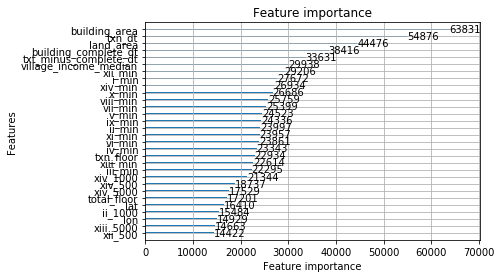

In [17]:
print('Plotting feature importances...')
ax = lgb.plot_importance(model_lgb, 
                         # figsize=(36, 72), 
                         max_num_features=30)
plt.show()

In [18]:
# LGB_GBDT計算val分數 (y_val也要轉換回來總價)
y_val_orig = np.expm1(y_val_test)
pred_price_lgb = model_lgb.predict(X_val_test)
pred_price_lgb = np.expm1(pred_price_lgb)

print("Hit Rate:", hit_rate(y_true=y_val_orig, y_hat=pred_price_lgb))

Hit Rate: 5433.866901766416


In [19]:
model_lgb.booster_.save_model('model_lgb_n1hot.txt')
# model_lgb = lgb.Booster(model_file='model_lgb_n1hot.txt')

##### LightGBM (DART)

In [85]:
# lightGBM (dart)
model_dart = LGBMRegressor(objective='regression', # regression, L2 loss, aliases: regression_l2, l2, mean_squared_error, mse, l2_root, root_mean_squared_error, rmse
                             boosting_type='dart',
                             num_leaves=31,  # < 2^max_depth
                             reg_lambda=1,
                             learning_rate=0.05, # 0.1
                             n_estimators=10,
                             # max_bin=200, # default=255
                             bagging_fraction=0.8,
                             # bagging_freq=5, 
                             # bagging_seed=7,
                             feature_fraction=0.9,
                             # drop_rate=0.3,  # default=0.1
                             max_drop=50, # 10  # default=50, 每iteration最多丟掉幾顆樹
                             skip_drop=0.5, # 0.6 # default=0.5 每iteration決定dropout的機率
                             # xgboost_dart_mode=True,  # default=False, 是否要用xgb的dart模式
                             # uniform_drop=True,  # set this to true, if you want to use uniform drop
                             # drop_seed=11,  # random seed to choose dropping models
                             # early_stopping_rounds=100
                             # feature_fraction_seed=7
                         )

print_callback = lgb.print_evaluation(period=100)

result = model_dart.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              # categorical_feature=categorical_feature_idx,
              # early_stopping_rounds=100, # 在dart不能用，因為每一輪整個模型參數都會被更新
              verbose=0,
              callbacks=[print_callback]
             )


In [93]:
result.best_score_['valid_0']['rmse']

0.6952194105643495

In [20]:
# 計算val分數 (y_val也要轉換回來總價)
y_val_orig = np.expm1(y_val_test) * X_val_test["building_area"]
pred_price_dart = model_dart.predict(X_val_test)
pred_price_dart = np.expm1(pred_price_dart) * X_val_test["building_area"]

print("Hit Rate:", hit_rate(y_true=y_val_orig, y_hat=pred_price_dart))

Hit Rate: 5973.878492352312


In [21]:
model_dart.booster_.save_model('model_dart_n1hot.txt')
# model_dart = lgb.Booster(model_file='model_dart_n1hot.txt')

In [ ]:
# TODO: one-hot encoding試試
# TODO: 加lgb, xgb做satcking
# TODO: hyperprot

In [126]:
print(np.expm1(16.16))
print(np.expm1(16.36))
print(np.expm1(17.26))  # 在房價+expm1的情況下，差1.1差很多~~~

10427946.296650684
12736722.590078022
31327283.968102083


### 模型調參

Apply __hyperopt__ to auto tune hyperparameters (<a href="https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Bayesian%20Hyperparameter%20Optimization%20of%20Gradient%20Boosting%20Machine.ipynb">ref</a>):

- Example code

```python
from hyperopt import hp, tpe, fmin 
# we import tpe algorithm 
# fmin function which helps us minimize the equation
# hp which creates the search space
# creating the objective function
def function(args):
    x,y = args
    f = x**2 - y**2
    return f           # returns a numerical value

# defining the search space, we'll explore this more later
space = [hp.uniform('x',-1,1),hp.uniform('y',-2,3)]

# calling the hyperopt function
best = fmin(function,space,algo=tpe.suggest,max_evals=10)
# fmin function’s first argument is the objective function
# second argument is the hyperopt space
# third the algorithm that is to be used for optimization
# maximum number of evaluations
# fmin returns a dictionary giving best hyper-parameter
print(best) 
```

- hp.uniform(label,low,high)参数在low和high之间均匀分布。 
- hp.quniform(label,low,high,q),参数的取值是round(uniform(low,high)/q)*q，适用于那些离散的取值。 
- hp.loguniform(label,low,high)绘制exp(uniform(low,high)),变量的取值范围是[exp(low),exp(high)] 
- hp.randint(label,upper) 返回一个在[0,upper)前闭后开的区间内的随机整数。 

In [43]:
from hyperopt import STATUS_OK

# Domain Space
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

# Optimization Algorithm
from hyperopt import tpe, fmin, Trials

from timeit import default_timer as timer

##### Create Domain Space (parameter space)

In [58]:
# 需對每個要調的參數創造空間

"""
Demo
"""
# learning rate: 
# learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}
# learning_rate_dist = []
# Draw 10000 samples from the learning rate domain
# for _ in range(10000):
#     learning_rate_dist.append(sample(learning_rate)['learning_rate'])  # 檢視抽樣空間結果

# num_leaves
# num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
# num_leaves_dist = []

# boosting type domain
# boosting_type = {'boosting_type':
#                      hp.choice('boosting_type',
#                                [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)},
#                                 {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
#                                 {'boosting_type': 'goss', 'subsample': 1.0}]
#                                )
#                  }
# Draw a sample
# params_set = sample(boosting_type)

space = {
    'boosting_type': 'dart',
    'objective': 'regression',
    # 'n_estimators': hp.quniform('num_leaves', 100, 5000, 1),
#     'class_weight': hp.choice('class_weight', [None, 'balanced']),
#     'boosting_type': hp.choice('boosting_type',
#                                [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)},
#                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
#                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 80, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0005), np.log(0.2)),
    # 'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    # 'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    # 'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 2.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.6, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0),
    'max_drop': hp.quniform('max_drop', 30, 60, 5),
    'skip_drop': hp.uniform('skip_drop', 0.5, 0.8),
    'drop_rate': hp.uniform('drop_rate', 0.1, 0.5)
}

In [65]:
# Sample from the full space
example = sample(space)

# Dictionary get method with default
# subsample = example['boosting_type'].get('subsample', 1.0)

# Assign top-level keys
# example['boosting_type'] = example['boosting_type']['boosting_type']
# example['subsample'] = subsample

example

{'bagging_fraction': 0.8230801272352318,
 'boosting_type': 'dart',
 'drop_rate': 0.37139376006054425,
 'feature_fraction': 0.8839177850427065,
 'learning_rate': 0.15881917220481517,
 'max_drop': 55.0,
 'num_leaves': 56.0,
 'objective': 'regression',
 'reg_lambda': 0.006387755980373333,
 'skip_drop': 0.7888174469758655}

##### Objective function

In [96]:
# N_FOLDS = 5

# Create the dataset
# train_set = lgb.Dataset(X_train_hyper, y_train_hyper)

def objective(params):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    
    # 放那些只吃整數的參數
    for parameter_name in ['num_leaves', 'max_drop']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evalute based on ROC AUC
#     cv_results = lgb.cv(params, 
#                         train_set, 
#                         nfold=n_folds, 
#                         num_boost_round=100, # 先放1000去看~
#                         # early_stopping_rounds=100,  # not work for dart
#                         metrics='rmse', 
#                         # seed=50,
#                         stratified=False)
    
    
    model_dart = LGBMRegressor(objective='regression', # regression, L2 loss, aliases: regression_l2, l2, mean_squared_error, mse, l2_root, root_mean_squared_error, rmse
                             boosting_type='dart',
                             num_leaves=params['num_leaves'],  # < 2^max_depth
                             reg_lambda=params['reg_lambda'],
                             # reg_alpha=params['reg_alpha'],
                             learning_rate=0.1, # 先設一樣的learning rate去調
                             n_estimators=1000,
                             bagging_fraction=params['bagging_fraction'],
                             feature_fraction=params['feature_fraction'],
                             drop_rate=params['drop_rate'],  # default=0.1
                             max_drop=params['max_drop'], # 10  # default=50, 每iteration最多丟掉幾顆樹
                             skip_drop=params['skip_drop'], # 0.6 # default=0.5 每iteration決定dropout的機率
                             # xgboost_dart_mode=True,  # default=False, 是否要用xgb的dart模式
                             # uniform_drop=True,  # set this to true, if you want to use uniform drop
                             # drop_seed=11,  # random seed to choose dropping models
                             # early_stopping_rounds=100
                             # feature_fraction_seed=7
                         )

    print_callback = lgb.print_evaluation(period=1000)

    fit_result = model_dart.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)],
                  eval_metric='rmse',
                  # categorical_feature=categorical_feature_idx,
                  # early_stopping_rounds=100, # 在dart不能用，因為每一輪整個模型參數都會被更新
                  verbose=0,
                  callbacks=[print_callback]
                 )
    
    
    # print(cv_results)
    # stratify works only with classification problems. So to work with regression, you need to make it False.
    
    run_time = timer() - start
    
    # Extract the best score
    loss = fit_result.best_score_['valid_0']['rmse']
    
    # Boosting rounds that returned the highest cv score
    # n_estimators = int(np.argmax(cv_results['rmse-mean']) + 1)
    
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, run_time])
    of_connection.close()
    
    # Loss must be minimized
    # loss = 1 - best_score
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'train_time': run_time, 'status': STATUS_OK}

##### Optimization Algorithm

In [67]:
# Algorithm
tpe_algorithm = tpe.suggest

##### Result History

Keeping track of the results is not strictly necessary as Hyperopt will do this internally for the algorithm. However, if we want to find out what is going on behind the scenes, we can use a `Trials` object which will store basic training information and also the dictionary returned from the objective function (which includes the `loss` and `params`). Making a trials object is one line:

In [98]:
# Keep track of results
bayes_trials = Trials()

In [99]:
import csv

# File to save first results
out_file = 'lgb_dart_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'train_time'])
of_connection.close()

##### Optimization

In [100]:
from hyperopt import fmin

MAX_EVALS = 100

# Optimize
best = fmin(fn=objective, space=space, algo=tpe.suggest,
            max_evals=MAX_EVALS, trials=bayes_trials)

[1000]	valid_0's l2: 0.0456733	valid_0's rmse: 0.213713
[1000]	valid_0's l2: 0.0846347	valid_0's rmse: 0.29092                          
[1000]	valid_0's l2: 0.0461643	valid_0's rmse: 0.214859                         
[1000]	valid_0's l2: 0.0555906	valid_0's rmse: 0.235776                         
[1000]	valid_0's l2: 0.0816345	valid_0's rmse: 0.285718                         
[1000]	valid_0's l2: 0.0478209	valid_0's rmse: 0.21868                          
[1000]	valid_0's l2: 0.0467738	valid_0's rmse: 0.216272                         
[1000]	valid_0's l2: 0.0913304	valid_0's rmse: 0.302209                         
[1000]	valid_0's l2: 0.0478096	valid_0's rmse: 0.218654                         
[1000]	valid_0's l2: 0.0539069	valid_0's rmse: 0.232179                         
[1000]	valid_0's l2: 0.0498985	valid_0's rmse: 0.22338                           
[1000]	valid_0's l2: 0.0548175	valid_0's rmse: 0.234131                          
[1000]	valid_0's l2: 0.051865	valid_0's rmse: 0.227

In [101]:
# lr固定(0.1)、樹數量固定(1000)的情況下的結果
bayes_trials_results = sorted(bayes_trials.results, key=lambda x: x['loss'])
print(bayes_trials_results[:2])

[{'loss': 0.201829474776178, 'params': {'bagging_fraction': 0.771097780208793, 'boosting_type': 'dart', 'drop_rate': 0.39474627060184564, 'feature_fraction': 0.8451612392236694, 'learning_rate': 0.0009052917399249793, 'max_drop': 35, 'num_leaves': 57, 'objective': 'regression', 'reg_lambda': 1.0686063692682688, 'skip_drop': 0.7923089201010893}, 'train_time': 38.52958648279309, 'status': 'ok'}, {'loss': 0.2036164576442454, 'params': {'bagging_fraction': 0.8562733758631089, 'boosting_type': 'dart', 'drop_rate': 0.4702181504569416, 'feature_fraction': 0.898401349461685, 'learning_rate': 0.00311500935648041, 'max_drop': 35, 'num_leaves': 54, 'objective': 'regression', 'reg_lambda': 0.00029092832329535856, 'skip_drop': 0.7916396373072634}, 'train_time': 41.154855851083994, 'status': 'ok'}]


##### retrain the model

In [20]:
# lightGBM (dart)
model_dart_tuned = LGBMRegressor(objective='regression', # regression, L2 loss, aliases: regression_l2, l2, mean_squared_error, mse, l2_root, root_mean_squared_error, rmse
                             boosting_type='dart',
                             num_leaves=57,  # < 2^max_depth
                             reg_lambda=1.06,
                             learning_rate=0.05, # 0.1
                             n_estimators=50000,
                             # max_bin=200, # default=255
                             bagging_fraction=0.77,
                             # bagging_freq=5, 
                             # bagging_seed=7,
                             feature_fraction=0.84,
                             drop_rate=0.39,  # default=0.1
                             max_drop=35, # 10  # default=50, 每iteration最多丟掉幾顆樹
                             skip_drop=0.79, # 0.6 # default=0.5 每iteration決定dropout的機率
                             # xgboost_dart_mode=True,  # default=False, 是否要用xgb的dart模式
                             # uniform_drop=True,  # set this to true, if you want to use uniform drop
                             # drop_seed=11,  # random seed to choose dropping models
                             # early_stopping_rounds=100
                             # feature_fraction_seed=7
                         )

print_callback = lgb.print_evaluation(period=500)

result = model_dart_tuned.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              # categorical_feature=categorical_feature_idx,
              # early_stopping_rounds=100, # 在dart不能用，因為每一輪整個模型參數都會被更新
              verbose=0,
              callbacks=[print_callback]
             )


[500]	valid_0's rmse: 0.493767	valid_0's l2: 0.243806
[1000]	valid_0's rmse: 0.256777	valid_0's l2: 0.0659342
[1500]	valid_0's rmse: 0.208729	valid_0's l2: 0.0435677
[2000]	valid_0's rmse: 0.20991	valid_0's l2: 0.0440623
[2500]	valid_0's rmse: 0.204729	valid_0's l2: 0.041914
[3000]	valid_0's rmse: 0.200142	valid_0's l2: 0.040057
[3500]	valid_0's rmse: 0.210202	valid_0's l2: 0.0441849
[4000]	valid_0's rmse: 0.201155	valid_0's l2: 0.0404634
[4500]	valid_0's rmse: 0.198744	valid_0's l2: 0.0394991
[5000]	valid_0's rmse: 0.197816	valid_0's l2: 0.0391311
[5500]	valid_0's rmse: 0.197833	valid_0's l2: 0.0391377
[6000]	valid_0's rmse: 0.197552	valid_0's l2: 0.0390268
[6500]	valid_0's rmse: 0.195308	valid_0's l2: 0.0381453
[7000]	valid_0's rmse: 0.195665	valid_0's l2: 0.0382849
[7500]	valid_0's rmse: 0.194902	valid_0's l2: 0.0379867
[8000]	valid_0's rmse: 0.195763	valid_0's l2: 0.0383231
[8500]	valid_0's rmse: 0.194648	valid_0's l2: 0.0378878
[9000]	valid_0's rmse: 0.194491	valid_0's l2: 0.03782

In [21]:
# 計算val分數 (y_val也要轉換回來總價)
y_val_orig = np.expm1(y_val_test) * X_val_test["building_area"]
pred_price_dart_tuned = model_dart_tuned.predict(X_val_test)
pred_price_dart_tuned = np.expm1(pred_price_dart_tuned) * X_val_test["building_area"]

print("Hit Rate:", hit_rate(y_true=y_val_orig, y_hat=pred_price_dart_tuned))

# 從6017提升到6037，算是有tuned到~

Hit Rate: 6037.880667746821


### 模型融合

Stacking時用調參後的模型去做ensemble，第二層用Linear的好處是可以看模型之間的權重分布。
https://zhuanlan.zhihu.com/p/26890738
TODO: 或用scipy.optimize.basinhopping去找oof預測的最佳權重組合跟y最靠近

```python
def fun(x):
    x = np.exp(x) / np.sum(np.exp(x))
    pred = np.sum(meta_feature * x, axis=-1)
    mse = calc_mse(y_train_csv, pred)
    return mse

result = scipy.optimize.basinhopping(fun, (0.0, 0.0, 0.0), niter=1000, disp=True)
meta_weight = np.exp(result.x) / np.sum(np.exp(result.x))
print(meta_weight)
```
![title](./stacking_meta權重示意圖.png)

example: https://github.com/GitYCC/tbrain_esun_house_price_predict/blob/master/src/train.py

scipy: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.basinhopping.html


```python
# KFOLD example
import numpy as np
from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6, 7, 8])
kf = KFold(n_splits=4)
kf.get_n_splits(X)

print(kf)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# np.column_satck
>>> a = np.array((1,2,3))
>>> b = np.array((2,3,4))
>>> np.column_stack((a,b))
array([[1, 2],
       [2, 3],
       [3, 4]])
    ```
Stacking for 每個model都要做一組train&test新特徵，也就是下面這張圖
![title](.\stacking.png)

In [17]:
# log狀態下融合完 vs exp完後融合
from sklearn.base import clone

def calc_mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

class stacking():
    def __init__(self,models, meta_model):
        self.models = models
        self.meta_model = meta_model
        # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self, X, y, df_type='pandas', model_type=[]):
        self.base_models = [list() for i in self.models]
        self.oof_train = np.zeros((X.shape[0], len(self.models)))
        
        for i, model in enumerate(self.models):
            print("training model:", i)
            # 每個base_model都共有k個fold要訓練
            for j, (train_index, test_index) in enumerate(self.kf.split(X, y)):
                print("training fold:", j)
                renew_model = clone(model)
                # oof的預測值為新特徵
                if df_type == 'pandas':
                    if model_type[i] == 'cat':
                        X_ = X.copy()
                        for col in X.columns[categorical_feature_idx]:
                            X_[col] = X_[col].astype('str')
                        renew_model.fit(X_.iloc[train_index], y.iloc[train_index],
                                       cat_features=categorical_feature_idx,
                                       use_best_model=False)
                        self.oof_train[test_index, i] = renew_model.predict(X_.iloc[test_index])
                    else:
                        renew_model.fit(X.iloc[train_index], y.iloc[train_index])
                        self.oof_train[test_index, i] = renew_model.predict(X.iloc[test_index])
                else:
                    renew_model.fit(X[train_index], y[train_index])
                    self.oof_train[test_index, i] = renew_model.predict(X[test_index])
                
                self.base_models[i].append(renew_model)
        # find_best_weight
        self.ground_y = y
        result = scipy.optimize.basinhopping(self.weight_func, (0.0, 0.0, 0.0), niter=1000, disp=True)
        self.meta_weight = np.exp(result.x) / np.sum(np.exp(result.x))
        print(self.meta_weight)
        
        self.meta_model.fit(self.oof_train, y)
        return self

    def predict(self, X):
        # for 每一個model會有k個訓練好的模型，直接預測test set(不用切) K次之後平均起來當作該model新特徵
        # 蒐集好所有model的test新特徵之後再column_stack起來，變成最後的test新特徵(維度=n個model)
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.base_models])
        # whole test會是n個model維
        self.hopping_pred = np.sum(self.meta_weight * whole_test, axis=-1)
        return self.meta_model.predict(whole_test)
    
    def weight_func(self, x):
        x = np.exp(x) / np.sum(np.exp(x))  # softmax
        pred = np.sum(self.oof_train * x, axis=-1)
        mse = calc_mse(self.ground_y, pred)
        return mse
    
    def get_oof(self, X, y, test_X):
        oof = np.zeros((X.shape[0],len(self.models)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.models)))
        for i,model in enumerate(self.models):
            for j, (train_index, test_index) in enumerate(self.kf.split(X, y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[test_index, i] = clone_model.predict(X[test_index])
                test_single[:, j] = clone_model.predict(test_X)
            test_mean[:, i] = test_single.mean(axis=1)
        return oof, test_mean
"""
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)

    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))

        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])

        self.meta_model.fit(oof_train,y)
        return self

    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)

    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean
"""

'\nclass stacking(BaseEstimator, RegressorMixin, TransformerMixin):\n    def __init__(self,mod,meta_model):\n        self.mod = mod\n        self.meta_model = meta_model\n        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)\n\n    def fit(self,X,y):\n        self.saved_model = [list() for i in self.mod]\n        oof_train = np.zeros((X.shape[0], len(self.mod)))\n\n        for i,model in enumerate(self.mod):\n            for train_index, val_index in self.kf.split(X,y):\n                renew_model = clone(model)\n                renew_model.fit(X[train_index], y[train_index])\n                self.saved_model[i].append(renew_model)\n                oof_train[val_index,i] = renew_model.predict(X[val_index])\n\n        self.meta_model.fit(oof_train,y)\n        return self\n\n    def predict(self,X):\n        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) \n                                      for single_model in self.

##### Weighted Sum

In [19]:
# Data preprocessing
X_val_test_cat = X_val_test.copy()

for col in X_val_test.columns[categorical_feature_idx]:
    X_val_test_cat[col] = X_val_test_cat[col].astype('str')
    X_val_test[col] = X_val_test[col].astype('category')

# load models
model_cat = catboost.CatBoostRegressor()
model_cat.load_model("(After)cat_model_total_1hot(nVillage_nTown).dump")
model_lgb = lgb.Booster(model_file='model_lgb_n1hot.txt')
model_dart = lgb.Booster(model_file='model_dart_n1hot.txt')# 純粹weighted sum

cat_pred = model_cat.predict(X_val_test_cat)
lgb_pred = model_lgb.predict(X_val_test)
dart_pred = model_dart.predict(X_val_test)

# 先sum再轉換 (6077分)
# ws_pred = 0.7 * dart_pred + 0.3 * cat_pred # + 0.1 * lgb_pred
# ws_pred = np.expm1(ws_pred)

# 先轉換再sum (6077分)
dart_pred_orig = np.expm1(dart_pred)
cat_pred_orig = np.expm1(cat_pred)
lgb_pred_orig = np.expm1(lgb_pred)
ws_pred = 0.7 * dart_pred_orig + 0.3 * cat_pred_orig # + 0.1 * lgb_pred_orig

y_val_orig = np.expm1(y_val_test)

print("Hit Rate:", hit_rate(y_true=y_val_orig, y_hat=ws_pred))

Hit Rate: 6077.879554570231


##### Stacking

In [18]:
# base models
# model_cat = catboost.CatBoostRegressor(iterations=30000,
#                               learning_rate=0.005,
#                               depth=10,
#                               eval_metric='RMSE',
#                               # random_seed=11,
#                               # l2_leaf_reg=4,
#                               # one_hot_max_size=100,
#                               # rsm=0.5,
#                               metric_period=500,
#                               # plot=True,
#                               # subsample=0.5,
#                               early_stopping_rounds=100)

model_lgb = LGBMRegressor(objective='regression',
                             boosting_type='gbdt',
                             num_leaves=31,  # < 2^max_depth
                             # reg_lambda=1,
                             learning_rate=0.005,
                             n_estimators=10000,  # 30000
                             # max_bin=200, # default=255
                             bagging_fraction=0.9,
                             # bagging_freq=5, 
                             # bagging_seed=7,
                             feature_fraction=0.9,
                             # early_stopping_rounds=100
                             # feature_fraction_seed=7
                         )
model_dart = LGBMRegressor(objective='binary', # regression, L2 loss, aliases: regression_l2, l2, mean_squared_error, mse, l2_root, root_mean_squared_error, rmse
                             boosting_type='dart',
                             num_leaves=31,  # < 2^max_depth
                             reg_lambda=1,
                             learning_rate=0.1,
                             n_estimators=10000,  # 30000
                             # max_bin=200, # default=255
                             bagging_fraction=0.8,
                             # bagging_freq=5, 
                             # bagging_seed=7,
                             feature_fraction=0.9,
                             # drop_rate=0.3,  # default=0.1
                             max_drop=10,  # default=50, 每iteration最多丟掉幾顆樹
                             skip_drop=0.6,  # default=0.5 每iteration決定dropout的機率
                             # xgboost_dart_mode=True,  # default=False, 是否要用xgb的dart模式
                             # uniform_drop=True,  # set this to true, if you want to use uniform drop
                             # drop_seed=11,  # random seed to choose dropping models
                             # early_stopping_rounds=100
                             # feature_fraction_seed=7
                         )

model_dart_tuned = LGBMRegressor(objective='regression', # regression, L2 loss, aliases: regression_l2, l2, mean_squared_error, mse, l2_root, root_mean_squared_error, rmse
                             boosting_type='dart',
                             num_leaves=57,  # < 2^max_depth
                             reg_lambda=1.06,
                             learning_rate=0.05, # 0.1
                             n_estimators=10000,  # 50000
                             # max_bin=200, # default=255
                             bagging_fraction=0.77,
                             # bagging_freq=5, 
                             # bagging_seed=7,
                             feature_fraction=0.84,
                             drop_rate=0.39,  # default=0.1
                             max_drop=35, # 10  # default=50, 每iteration最多丟掉幾顆樹
                             skip_drop=0.79, # 0.6 # default=0.5 每iteration決定dropout的機率
                             # xgboost_dart_mode=True,  # default=False, 是否要用xgb的dart模式
                             # uniform_drop=True,  # set this to true, if you want to use uniform drop
                             # drop_seed=11,  # random seed to choose dropping models
                             # early_stopping_rounds=100
                             # feature_fraction_seed=7
                         )

# model_dart2 = LGBMRegressor(objective='regression', # regression, L2 loss, aliases: regression_l2, l2, mean_squared_error, mse, l2_root, root_mean_squared_error, rmse
#                              boosting_type='dart',
#                              num_leaves=31,  # < 2^max_depth
#                              reg_lambda=1,
#                              learning_rate=0.05,
#                              n_estimators=30000,
#                              # max_bin=200, # default=255
#                              bagging_fraction=0.8,
#                              # bagging_freq=5, 
#                              # bagging_seed=7,
#                              feature_fraction=0.9,
#                              # drop_rate=0.3,  # default=0.1
#                              # max_drop=20,  # default=50, 每iteration最多丟掉幾顆樹
#                              skip_drop=0.6,  # default=0.5 每iteration決定dropout的機率
#                              # xgboost_dart_mode=True,  # default=False, 是否要用xgb的dart模式
#                              # uniform_drop=True,  # set this to true, if you want to use uniform drop
#                              # drop_seed=11,  # random seed to choose dropping models
#                              # early_stopping_rounds=100
#                              # feature_fraction_seed=7
#                          )

In [19]:
# Stacking參考
# https://github.com/Tang-Li-Jen/T_Brain_Malware_Detection_Competition/blob/master/StackModel.py

In [20]:
# meta model

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

# X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# # y = 1 * x_0 + 2 * x_1 + 3
# y = np.dot(X, np.array([1, 2])) + 3
# reg = LinearRegression().fit(X, y)
# reg.score(X, y)
# reg.coef_
# reg.intercept_ 
# reg.predict(np.array([[3, 5]]))

In [21]:
X_train_r = X_train.reset_index(drop=True)
y_train_r = y_train.reset_index(drop=True)
X_val_test_r = X_val_test.reset_index(drop=True)
y_val_test_r = y_val_test.reset_index(drop=True)

# model_cat, 跟其他人不一樣先待解
# 叫一下meta model
stack_model = stacking(models=[model_lgb, model_dart, model_dart_tuned], meta_model=reg)
stack_model.fit(X_train_r, y_train_r, model_type=['lgb', 'lgb', 'lgb'])
pred_stack = np.expm1(stack_model.predict(X_val_test_r))

y_val_orig = np.expm1(y_val_test_r)

print(stack_model.meta_weight)
print(stack_model.meta_model.coef_)
print(stack_model.meta_model.intercept_)

print("Hit Rate:", hit_rate(y_true=y_val_orig, y_hat=pred_stack))

training model: 0
training fold: 0
training fold: 1
training fold: 2
training fold: 3
training fold: 4
training model: 1
training fold: 0
training fold: 1
training fold: 2
training fold: 3
training fold: 4
training model: 2
training fold: 0
training fold: 1
training fold: 2
training fold: 3
training fold: 4
basinhopping step 0: f 0.0377645
basinhopping step 1: f 0.0377642 trial_f 0.0377642 accepted 1  lowest_f 0.0377642
found new global minimum on step 1 with function value 0.0377642
basinhopping step 2: f 0.0377646 trial_f 0.0377646 accepted 1  lowest_f 0.0377642
basinhopping step 3: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 4: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 5: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 6: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 7: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 8

basinhopping step 93: f 0.0377646 trial_f 0.0377646 accepted 1  lowest_f 0.0377642
basinhopping step 94: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 95: f 0.0377646 trial_f 0.0377646 accepted 1  lowest_f 0.0377642
basinhopping step 96: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 97: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 98: f 0.0377646 trial_f 0.0377646 accepted 1  lowest_f 0.0377642
basinhopping step 99: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
adaptive stepsize: acceptance rate 0.990000 target 0.500000 new stepsize 0.617284 old stepsize 0.555556
basinhopping step 100: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 101: f 0.0377642 trial_f 0.0377642 accepted 1  lowest_f 0.0377642
basinhopping step 102: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 103: f 0.0377645 trial_f 0.0377645 accepted 1

basinhopping step 189: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 190: f 0.0377642 trial_f 0.0377642 accepted 1  lowest_f 0.0377642
basinhopping step 191: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 192: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 193: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 194: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 195: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 196: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 197: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 198: f 0.0377646 trial_f 0.0377646 accepted 1  lowest_f 0.0377642
basinhopping step 199: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
adaptive stepsize: acceptance rate 0.995000 target 0.500000 new stepsize 0.7

basinhopping step 285: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 286: f 0.0377642 trial_f 0.0377642 accepted 1  lowest_f 0.0377642
basinhopping step 287: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 288: f 0.0377642 trial_f 0.0377642 accepted 1  lowest_f 0.0377642
basinhopping step 289: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 290: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 291: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 292: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 293: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 294: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 295: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 296: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.

basinhopping step 381: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 382: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 383: f 0.0377642 trial_f 0.0377642 accepted 1  lowest_f 0.0377642
basinhopping step 384: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 385: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 386: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 387: f 0.0377642 trial_f 0.0377642 accepted 1  lowest_f 0.0377642
basinhopping step 388: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 389: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 390: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 391: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 392: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.

basinhopping step 477: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 478: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 479: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 480: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 481: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 482: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 483: f 0.0377646 trial_f 0.0377646 accepted 1  lowest_f 0.0377642
basinhopping step 484: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 485: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 486: f 0.0377646 trial_f 0.0377646 accepted 1  lowest_f 0.0377642
basinhopping step 487: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 488: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.

basinhopping step 573: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 574: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 575: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 576: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 577: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 578: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 579: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 580: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 581: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 582: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 583: f 0.0377645 trial_f 0.0377645 accepted 1  lowest_f 0.0377642
basinhopping step 584: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.

basinhopping step 670: f 0.0378634 trial_f 0.0378634 accepted 1  lowest_f 0.0377642
basinhopping step 671: f 0.0378634 trial_f 0.0378634 accepted 1  lowest_f 0.0377642
basinhopping step 672: f 0.0378635 trial_f 0.0378635 accepted 1  lowest_f 0.0377642
basinhopping step 673: f 0.0378635 trial_f 0.0378635 accepted 1  lowest_f 0.0377642
basinhopping step 674: f 0.0378634 trial_f 0.0378634 accepted 1  lowest_f 0.0377642
basinhopping step 675: f 0.0378635 trial_f 0.0378635 accepted 1  lowest_f 0.0377642
basinhopping step 676: f 0.0378634 trial_f 0.0378634 accepted 1  lowest_f 0.0377642
basinhopping step 677: f 0.0378632 trial_f 0.0378632 accepted 1  lowest_f 0.0377642
basinhopping step 678: f 0.0378635 trial_f 0.0378635 accepted 1  lowest_f 0.0377642
basinhopping step 679: f 0.0378635 trial_f 0.0378635 accepted 1  lowest_f 0.0377642
basinhopping step 680: f 0.0378635 trial_f 0.0378635 accepted 1  lowest_f 0.0377642
basinhopping step 681: f 0.0378635 trial_f 0.0378635 accepted 1  lowest_f 0.

basinhopping step 766: f 0.0378633 trial_f 0.0378633 accepted 1  lowest_f 0.0377642
basinhopping step 767: f 0.0378624 trial_f 0.0378624 accepted 1  lowest_f 0.0377642
basinhopping step 768: f 0.0378538 trial_f 0.0378538 accepted 1  lowest_f 0.0377642
basinhopping step 769: f 0.0378631 trial_f 0.0378631 accepted 1  lowest_f 0.0377642
basinhopping step 770: f 0.0378634 trial_f 0.0378634 accepted 1  lowest_f 0.0377642
basinhopping step 771: f 0.0378635 trial_f 0.0378635 accepted 1  lowest_f 0.0377642
basinhopping step 772: f 0.0378637 trial_f 0.0378637 accepted 1  lowest_f 0.0377642
basinhopping step 773: f 0.0378635 trial_f 0.0378635 accepted 1  lowest_f 0.0377642
basinhopping step 774: f 0.0378634 trial_f 0.0378634 accepted 1  lowest_f 0.0377642
basinhopping step 775: f 0.0378635 trial_f 0.0378635 accepted 1  lowest_f 0.0377642
basinhopping step 776: f 0.0378634 trial_f 0.0378634 accepted 1  lowest_f 0.0377642
basinhopping step 777: f 0.0378635 trial_f 0.0378635 accepted 1  lowest_f 0.

basinhopping step 863: f 0.0378631 trial_f 0.0378631 accepted 1  lowest_f 0.0377642
basinhopping step 864: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 865: f 0.0377646 trial_f 0.0377646 accepted 1  lowest_f 0.0377642
basinhopping step 866: f 0.0377642 trial_f 0.0377642 accepted 1  lowest_f 0.0377642
basinhopping step 867: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 868: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.0377642
basinhopping step 869: f 0.037854 trial_f 0.037854 accepted 1  lowest_f 0.0377642
basinhopping step 870: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 871: f 0.0378533 trial_f 0.0378533 accepted 1  lowest_f 0.0377642
basinhopping step 872: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 873: f 0.0377644 trial_f 0.0377644 accepted 1  lowest_f 0.0377642
basinhopping step 874: f 0.0377643 trial_f 0.0377643 accepted 1  lowest_f 0.03

basinhopping step 975: f 0.0381719 trial_f 0.0381719 accepted 1  lowest_f 0.0377642
basinhopping step 976: f 0.0381719 trial_f 0.0381719 accepted 1  lowest_f 0.0377642
basinhopping step 977: f 0.0381719 trial_f 0.0381719 accepted 1  lowest_f 0.0377642
basinhopping step 978: f 0.0381719 trial_f 0.0381719 accepted 1  lowest_f 0.0377642
basinhopping step 979: f 0.0381719 trial_f 0.0381719 accepted 1  lowest_f 0.0377642
basinhopping step 980: f 0.0381719 trial_f 0.0381719 accepted 1  lowest_f 0.0377642
basinhopping step 981: f 0.0381719 trial_f 0.0381719 accepted 1  lowest_f 0.0377642
basinhopping step 982: f 0.0381719 trial_f 0.0381719 accepted 1  lowest_f 0.0377642
basinhopping step 983: f 0.0381719 trial_f 0.0381719 accepted 1  lowest_f 0.0377642
basinhopping step 984: f 0.0381719 trial_f 0.0381719 accepted 1  lowest_f 0.0377642
basinhopping step 985: f 0.0381719 trial_f 0.0381719 accepted 1  lowest_f 0.0377642
basinhopping step 986: f 0.0381719 trial_f 0.0381719 accepted 1  lowest_f 0.

/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


[0.11190049 0.42311259 0.46498692]
[0.11267828 0.42891362 0.46379906]
-0.0668227010681619
Hit Rate: 5833.876267262014


### 提交

In [72]:
ans_table = pd.read_csv("submit_test.csv")
ans_table["total_price"] = np.expm1(pred_price)
ans_table.to_csv("0630_ft_tools_mxdep_1.csv", index=False)

In [123]:
# model_cat.save_model("cat_model_0607_full_1_dim_coord.dump")
model = catboost.CatBoostRegressor()
model.load_model('cat_model_0607_full_1_dim_coord.dump')

In [ ]:
ans_table = pd.read_csv("submit_test.csv")
# 單位價格預測，先用log值乘上總面積再換算回來exp
pred_price = model_cat.predict(X_test)
pred_price = np.expm1(pred_price * X_test["building_area"])
# pred_price = model_cat.predict(X_test)
sns.distplot(pred_price)
ans_table["total_price"] = np.expm1(pred_price)
ans_table["total_price"]

### Featuretools for feature engineering
Now we can start using Featuretools to perform automated feature engineering! It is necessary to have a unique identifier feature in the dataset.

In [15]:
import featuretools.variable_types as vtypes
app_types = {}
for bool_col in qualitative:
    if "index" in bool_col:
        app_types[bool_col] = vtypes.Boolean

In [16]:
for cat_col in qualitative:
    if "index" not in cat_col:
        app_types[cat_col] = vtypes.Categorical

In [17]:
# featuretools for automated feature engineering
import featuretools as ft
print(features.shape)
print(features.columns)
# Entity set with id applications
es = ft.EntitySet(id = 'building_id')
es.entity_from_dataframe(entity_id='houseprice',
                         dataframe=features,
                         index='building_id',
                         variable_types=app_types)

(69847, 235)
Index(['bachelor_rate', 'born_rate', 'building_area', 'building_complete_dt',
       'building_id', 'building_material', 'building_type', 'building_use',
       'city', 'death_date',
       ...
       'xiv_250', 'xiv_50', 'xiv_500', 'xiv_5000', 'xiv_index_1000',
       'xiv_index_10000', 'xiv_index_50', 'xiv_index_500', 'xiv_index_5000',
       'xiv_min'],
      dtype='object', length=235)


Entityset: building_id
  Entities:
    houseprice [Rows: 69847, Columns: 235]
  Relationships:
    No relationships

In [18]:
es = es.normalize_entity(base_entity_id='houseprice', new_entity_id='city', index='city')
es = es.normalize_entity(base_entity_id='houseprice', new_entity_id='town', index='town')

In [19]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "skew", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine", "num_words"]

# DFS with specified primitives
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'houseprice',
                       trans_primitives = default_trans_primitives,
                       agg_primitives=default_agg_primitives,
                       max_depth = 2, n_jobs = -1, verbose = 1)

Built 1646 features
EntitySet scattered to workers in 5.296 seconds
Elapsed: 01:13 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [20]:
features = features.reset_index(drop=True)
feature_matrix = feature_matrix.reset_index(drop=True)

In [21]:
feature_matrix = pd.concat([features, feature_matrix], axis=1)
feature_matrix = feature_matrix.loc[:,~feature_matrix.columns.duplicated()]
feature_matrix.shape

(69847, 1649)

In [22]:
# features from featuretools
generated_fts = [name for name in feature_matrix.columns if name not in (qualitative + quantitative)]

In [23]:
# missing (feature_matrix)
feature_matrix.update(feature_matrix[generated_fts].fillna(0))

In [103]:
#經緯度揉成一維 (fotget it)
# from keras.layers import Dense, BatchNormalization, Input, Add, Activation
# from keras.models import Model
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# def nn_model(input_shape=2, output_shape=2):

#     input = Input(shape=(input_shape,))

#     encoded = Dense(8)(input)
#     encoded = BatchNormalization()(encoded)
#     encoded = Activation('relu')(encoded)
#     encoded = Dense(16)(encoded)
#     encoded = BatchNormalization()(encoded)
#     encoded = Activation('relu')(encoded)
#     encoded_output = Dense(1)(encoded)
#     decoded = Dense(16)(encoded_output)
#     decoded = BatchNormalization()(decoded)
#     decoded = Activation('relu')(decoded)
#     decoded = Dense(8)(decoded)
#     decoded = BatchNormalization()(decoded)
#     decoded = Activation('relu')(decoded)
#     decoded_output = Dense(output_shape, activation='linear')(decoded)
    
#     encoder = Model(input, encoded_output)
#     whole_model = Model(input, decoded_output)

#     return whole_model, encoder
# whole_model, lat_lon_encoder = nn_model()

# X = features[['lon', 'lat']].values

# early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=2)
# lr_reducer = ReduceLROnPlateau(monitor='var_loss', factor=0.5, patience=20)
# optimizer = Adam(lr=0.005, beta_1=0.5, beta_2=0.9)
# whole_model.compile(loss='mse', optimizer=optimizer)
# whole_model.fit(x=X, y=X, validation_split=0.2, epochs=500, batch_size=512, verbose=2,
#                 callbacks=[early_stopping, lr_reducer])


Train on 55877 samples, validate on 13970 samples
Epoch 1/500
 - 2s - loss: 7442.8931 - val_loss: 10525.2713
Epoch 2/500
 - 0s - loss: 6402.2148 - val_loss: 4594.8421
Epoch 3/500
 - 0s - loss: 4875.4083 - val_loss: 4658.1634
Epoch 4/500
 - 0s - loss: 3161.3891 - val_loss: 1917.3927
Epoch 5/500
 - 0s - loss: 1613.6306 - val_loss: 8739.6114
Epoch 6/500
 - 0s - loss: 514.2183 - val_loss: 62672.3176
Epoch 7/500
 - 0s - loss: 69.0247 - val_loss: 483.4934
Epoch 8/500
 - 0s - loss: 2.7305 - val_loss: 790.2695
Epoch 9/500
 - 0s - loss: 0.6672 - val_loss: 17.8391
Epoch 10/500
 - 0s - loss: 0.5532 - val_loss: 0.6400
Epoch 11/500
 - 0s - loss: 0.4453 - val_loss: 12.2882
Epoch 12/500
 - 0s - loss: 0.3948 - val_loss: 3.6980
Epoch 13/500
 - 0s - loss: 0.3867 - val_loss: 41.7391
Epoch 14/500
 - 0s - loss: 0.4459 - val_loss: 18.8785
Epoch 15/500
 - 0s - loss: 0.4687 - val_loss: 1.5564
Epoch 16/500
 - 0s - loss: 0.3888 - val_loss: 24.2329
Epoch 17/500
 - 0s - loss: 0.3395 - val_loss: 11.7007
Epoch 18/5

Epoch 153/500
 - 0s - loss: 0.0930 - val_loss: 1.3733
Epoch 154/500
 - 0s - loss: 0.0945 - val_loss: 119.1610
Epoch 155/500
 - 0s - loss: 0.1091 - val_loss: 2.3147
Epoch 156/500
 - 0s - loss: 0.1136 - val_loss: 1.0698
Epoch 157/500
 - 0s - loss: 0.1049 - val_loss: 2.2403
Epoch 158/500
 - 0s - loss: 0.1023 - val_loss: 1.4244
Epoch 159/500
 - 0s - loss: 0.0898 - val_loss: 1.5030
Epoch 160/500
 - 0s - loss: 0.1050 - val_loss: 4.2329
Epoch 161/500
 - 0s - loss: 0.1062 - val_loss: 5.3940
Epoch 162/500
 - 0s - loss: 0.1555 - val_loss: 3.1032
Epoch 163/500
 - 0s - loss: 0.1116 - val_loss: 1.7075
Epoch 164/500
 - 0s - loss: 0.1009 - val_loss: 2.1050
Epoch 165/500
 - 0s - loss: 0.0956 - val_loss: 2.3951
Epoch 166/500
 - 0s - loss: 0.0974 - val_loss: 6.2252
Epoch 167/500
 - 0s - loss: 0.1023 - val_loss: 1.6938
Epoch 168/500
 - 0s - loss: 0.1062 - val_loss: 7.5916
Epoch 169/500
 - 0s - loss: 0.0951 - val_loss: 4.9648
Epoch 170/500
 - 0s - loss: 0.1005 - val_loss: 5.4694
Epoch 171/500
 - 0s - loss

 - 0s - loss: 0.0582 - val_loss: 0.8085
Epoch 305/500
 - 0s - loss: 0.0681 - val_loss: 0.4674
Epoch 306/500
 - 0s - loss: 0.0649 - val_loss: 1.5998
Epoch 307/500
 - 0s - loss: 0.0667 - val_loss: 1.3644
Epoch 308/500
 - 0s - loss: 0.0653 - val_loss: 1.2361
Epoch 309/500
 - 0s - loss: 0.0702 - val_loss: 1.8172
Epoch 310/500
 - 0s - loss: 0.0929 - val_loss: 4.2450
Epoch 311/500
 - 0s - loss: 0.0620 - val_loss: 1.0484
Epoch 312/500
 - 0s - loss: 0.0670 - val_loss: 1.2674
Epoch 313/500
 - 0s - loss: 0.0703 - val_loss: 0.3063
Epoch 314/500
 - 0s - loss: 0.0601 - val_loss: 0.4611
Epoch 315/500
 - 0s - loss: 0.0681 - val_loss: 1.4772
Epoch 316/500
 - 0s - loss: 0.0632 - val_loss: 2.1808
Epoch 317/500
 - 0s - loss: 0.0641 - val_loss: 0.6243
Epoch 318/500
 - 0s - loss: 0.0649 - val_loss: 117.9558
Epoch 319/500
 - 0s - loss: 0.0591 - val_loss: 0.4089
Epoch 320/500
 - 0s - loss: 0.0647 - val_loss: 0.9316
Epoch 321/500
 - 0s - loss: 0.0752 - val_loss: 244.7587
Epoch 322/500
 - 0s - loss: 0.0702 - v